This code went through many iterations and, in total, I spent over 40 hours on it. Specifically, I trained my network roughly 10 times, some of which having non-numerated version (i.e. "nn5.pt" is the 5th iteration but may have had a "nn5batch.pt" with a slight modification, such as raising batch size).


The **current model** is a ResNet18 backbone followed by a single-layer classification section (512 -> 5) and a multi-layer regression section with two hidden layers (512 -> 1024 -> 512 -> 16). In this model I used no activation for the classification layer and used ReLU activations between each hidden layer in the regression layer.  Every layer contains dropout with p=0.5.

This version uses a loss function combination of CrossEntropy for classification and SmoothL1 for regression with a reduction method of summation. When combining these loss functions I multiply the regression loss by 4 (hyperparameter).

I also made some modifications to the training conditions for regression to significantly accelerate the training process. Instead of only backpropagating when the class was predicted correctly, I backpropagate every time for the ground truth (correct) classification. That way, the regression layer trains independent of the classification layer and can start improving from the start.

Over **previous models** I tried varying many parameters and conditions, including the following:
*   Size and number of layers in the regression layer (no hidden layers, one hidden, two, number of params per layer such as 1024 vs 512 in regression hidden layer)
*   Dropout and activation (ReLU and Softmax) layers
*   Regression Loss Function (MSELoss vs. SmoothL1, reduction by mean or summation) and weights during combination (2 vs. 4)
*   Batch Size (8, 32, 64) and shuffling of the dataloader
*   Optimizer parameters (learning rate .01, .001, and .0001)

I have also made the following **optimizations** as I trained my various models:
*   Multithreading of dataloaders
*   with torch.no_grad() for validation
*   Training model does not calculate IOU accuracy
*   Other various reductions of loops

With these optimizations I was able to train an epoch every 5 - 6 minutes. With these variations in my model I went from 20s after 30+ epochs to 50s in less than 3 epochs.

**IMPORTANT NOTE:** There is a bug in this current train() function where I forgot to edit the weight on the regression loss to 4 in the validation sequence. I have left this in out of transparency but it has no impact on the code as this loss is never backpropagated and selection of a best network is off of IOU accuracy.

**NOTE ON OLDER MODELS WITH BETTER GRAPHS:** This model contained my best accuracy but the graph for training loss over time is janky, as it mostly trained in the first epoch. The following is a link to a copy of an older network, complete with testing output, which shows more appropriate plots.
https://colab.research.google.com/drive/18DyAlZFJIzBqoeQPtPUnh1s-yOFVLLuO?usp=sharing


In [1]:
## Homework 5 Solution Template
### CSCI 4270 / 6270
### Due: April 8, 2024

In [3]:
import numpy as np
import json
from PIL import Image
from os.path import join

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms

import cv2
from matplotlib import pyplot as plt
import os
import copy

In [29]:
"""
Implement and test the utilities in support of evaluating the results
from the region-by-region decisions and turning them into detections.

All rectangles are four component lists (or tuples) giving the upper
left and lower right cornders of an axis-aligned rectangle.  For example,
[2, 9, 12, 18] has upper left corner (2,9) and lower right (12, 18)

The region predictions for an image for an image are stored in a list
of dictionaries, each giving the class, the activation and the
bounding rectangle.  For example,

{
    "class": 2,
    "a":  0.67,
    "rectangle": (18, 14, 50, 75)
}

if the class is 0 this means there is no detection and the rectangle
should be ignored.  The region predictions must be turned into the
detection results by filtering those with class 0 and through non
maximum supression.  The resulting regions should be considered the
"detections" for the image.

After this, detections should be compared to the ground truth

The ground truth regions for an image are stored as a list of dictionaries.
Each dictionary contains the region's class and bounding rectangle.
Here is an example dictionary:

{
    "class":  3,
    "rectangle": (15, 20, 56, 65)
}

Class 0 will not appear in the ground truth.
"""

def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """
    x0, y0, x1, y1 = rect1
    u0, v0, u1, v1 = rect2
    ir = (max(x0, u0), max(y0, v0), min(x1, u1), min(y1, v1))
    if ir[0] >= ir[2] or ir[1] >= ir[3]:
        return 0
    else:
        return area(ir) / (area(rect1) + area(rect2) - area(ir))


def predictions_to_detections(predictions, iou_threshold=0.5):
    """
    Input: List of region predictions

    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """
    # REDACTED

def evaluate(detections, gt_detections, iou_threshold=0.5):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The IOU threshold

    The calculation must compare each detection region to the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """
    # REDACTED



In [5]:
def test_iou():
    """
    Use this function for you own testing of your IOU function
    """
    # should be .370
    rect1 = (0, 5, 11, 15)
    rect2 = (2, 9, 12, 18)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0
    rect1 = (2, -3, 11, 4)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0.2
    rect1 = (3, 12, 9, 15)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

test_iou()

iou for (0, 5, 11, 15) (2, 9, 12, 18) is 0.37
iou for (2, -3, 11, 4) (2, 9, 12, 18) is 0.00
iou for (3, 12, 9, 15) (2, 9, 12, 18) is 0.20


In [6]:
def test_evaluation_code(in_json_file):
    with open(in_json_file, "r") as in_fp:
        data = json.load(in_fp)

    region_predictions = data["region_predictions"]
    gt_detections = data["gt_detections"]
    detections = predictions_to_detections(region_predictions)
    print(f"DETECTIONS: count = {len(detections)}")
    if len(detections) >= 2:
        print(f"DETECTIONS: first activation {detections[0]['a']:.2f}" )
        print(f"DETECTIONS: last activation {detections[-1]['a']:.2f}")
    elif len(detections) == 1:
        print(f"DETECTIONS: only activation {detections[0]['a']:.2f}")
    else:
        print(f"DETECTIONS: no activations")

    correct, incorrect, missed, ap = evaluate(detections, gt_detections)

    print(f"AP: num correct {len(correct)}")
    if len(correct) > 0:
        print(f"AP: first correct activation {correct[0]['a']:.2f}")

    print(f"AP: num incorrect {len(incorrect)}")
    if len(incorrect) > 0:
        print(f"AP: first incorrect activation {incorrect[0]['a']:.2f}")

    print(f"AP: num ground truth missed {len(missed)}")
    print(f"AP: final AP value {ap:1.3f}")


In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
folder_path = "/content/drive/MyDrive/hw5_data/"

Mounted at /content/drive


In [35]:
test_evaluation_code(folder_path + 'eval_test1.json')

DETECTIONS: count = 3
DETECTIONS: first activation 0.90
DETECTIONS: last activation 0.69
AP: num correct 1
AP: first correct activation 0.90
AP: num incorrect 2
AP: first incorrect activation 0.70
AP: num ground truth missed 2
AP: final AP value 0.576


In [36]:
test_evaluation_code(folder_path + 'eval_test2.json')

DETECTIONS: count = 5
DETECTIONS: first activation 0.94
DETECTIONS: last activation 0.55
AP: num correct 4
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.800


In [37]:
test_evaluation_code(folder_path + 'eval_test3.json')

DETECTIONS: count = 1
DETECTIONS: only activation 0.94
AP: num correct 0
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.000


In [38]:
test_evaluation_code(folder_path + 'eval_test4.json')

DETECTIONS: count = 11
DETECTIONS: first activation 0.89
DETECTIONS: last activation 0.65
AP: num correct 10
AP: first correct activation 0.89
AP: num incorrect 1
AP: first incorrect activation 0.88
AP: num ground truth missed 1
AP: final AP value 0.917


In [12]:
'''
Skeleton model class. You will have to implement the classification and regression layers, along with the forward definition.
'''

# REDACTED (NN ARCHITECTURE)


In [13]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# Dictionaries mapping class labels to names.
LABELS_TO_NAMES = {0: 'nothing',
                   1: 'bicycle',
                   2: 'car',
                   3: 'motorbike',
                   4: 'person',}


LABELS_TO_NAMES_LARGE = {0: 'nothing',
                         1: 'aeroplane',
                         2: 'bicycle',
                         3: 'bird',
                         4: 'boat',
                         5: 'bottle',
                         6: 'bus',
                         7: 'car',
                         8: 'cat',
                         9: 'chair',
                         10: 'cow',
                         11: 'diningtable',
                         12: 'dog',
                         13: 'horse',
                         14: 'motorbike',
                         15: 'person',
                         16: 'pottedplant',
                         17: 'sheep',
                         18: 'sofa',
                         19: 'train',
                         20: 'tvmonitor'}


class HW5Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
    Output:
        candidate_region - 3 x M x M tensor
        ground_truth_bbox - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root
        self.candidate_region_size = candidate_region_size

        self.images = []
        self.candidate_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_bboxes = torch.cat((self.candidate_bboxes, torch.tensor(val['bbox']).unsqueeze(0)))
                self.ground_truth_bboxes = torch.cat((self.ground_truth_bboxes, torch.tensor(val['gt_bbox']).unsqueeze(0)))
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])

        image = Image.open(image_path)

        # Crop the image to the candidate region.
        candidate_bbox = self.candidate_bboxes[idx, :]
        candidate_region = image.crop((candidate_bbox[0].item(), candidate_bbox[1].item(), candidate_bbox[2].item(), candidate_bbox[3].item()))

        width, height = candidate_region.size
        x_scale = self.candidate_region_size / width
        y_scale = self.candidate_region_size / height

        # Transform to resize, convert to tensor, and normalize.
        candidate_region = self.transform(candidate_region)

        # Resize ground truth bounding box.
        gt_bbox = self.ground_truth_bboxes[idx, :]
        resized_gt_x0 = (gt_bbox[0] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y0 = (gt_bbox[1] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        resized_gt_x1 = (gt_bbox[2] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y1 = (gt_bbox[3] - candidate_bbox[1]) * y_scale / self.candidate_region_size

        resized_gt_bbox = torch.tensor([resized_gt_x0, resized_gt_y0, resized_gt_x1, resized_gt_y1])

        return candidate_region, resized_gt_bbox, self.ground_truth_classes[idx]


class HW5DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
    Returns:
        image - numpy array A x B x 3 (RGB)
        candidate_regions - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_bboxes - all candidate bounding boxes for an image
        ground_truth_bboxes - all ground truth bounding boxes for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_bboxes = []
        self.ground_truth_bboxes = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)

            bboxes = torch.empty((len(values['candidate_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['candidate_bboxes']):
                bboxes[i, :] = torch.tensor(bbox)
            self.candidate_bboxes.append(bboxes)

            labels = torch.empty((len(values['gt_bboxes'])), dtype=int)
            bboxes = torch.empty((len(values['gt_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['gt_bboxes']):
                bboxes[i, :] = torch.tensor(bbox['bbox'])
                labels[i] = bbox['class']
            self.ground_truth_bboxes.append(bboxes)
            self.ground_truth_classes.append(labels)

        self.candidate_region_size = candidate_region_size

        # Transform to resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = Image.open(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_bboxes = self.candidate_bboxes[idx]
        candidate_regions = torch.empty((len(idx_candidate_bboxes), 3, self.candidate_region_size, self.candidate_region_size))
        for i, bbox in enumerate(idx_candidate_bboxes):
            candidate_region = image.crop((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
            candidate_region = self.transform(candidate_region)
            candidate_regions[i] = candidate_region

        return np.array(image), candidate_regions, self.candidate_bboxes[idx], self.ground_truth_bboxes[idx], self.ground_truth_classes[idx]


In [14]:
train_dataset = HW5Dataset("/content/drive/MyDrive/hw5_data_2024/train","/content/drive/MyDrive/hw5_data_2024/train.json")
validation_dataset = HW5Dataset("/content/drive/MyDrive/hw5_data_2024/valid","/content/drive/MyDrive/hw5_data_2024/valid.json")
test_dataset = HW5DatasetTest("/content/drive/MyDrive/hw5_data_2024/test","/content/drive/MyDrive/hw5_data_2024/test.json")

# OLD = 8
batch = 32

train_dataloader = DataLoader(train_dataset,batch_size=batch,num_workers=10,shuffle=True)
valid_dataloader = DataLoader(validation_dataset,batch_size=batch,num_workers=10,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = RCNN().to(device)
print(model)
for p in model.parameters():
    print(p.size())
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can al

RCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [15]:
# REDACTED (TRAINING FUNCTION)

In [16]:
# REDACTED (TESTING FUNCTION)

In [17]:
# REDACTED (PERFORMANCE STATISTIC FUNCTIONS)

In [18]:
# REDACTED (EPOCH TRAINING LOOP)

TRAINING STARTED FROM EPOCH 5
TOTAL BATCHES THIS ROUND: 740


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


BATCH 0: TOTAL LOSS 5.066417694091797
BATCH 100: TOTAL LOSS 406.76638436317444
BATCH 200: TOTAL LOSS 812.27246260643
BATCH 300: TOTAL LOSS 1231.1437647342682
BATCH 400: TOTAL LOSS 1648.8272969722748
BATCH 500: TOTAL LOSS 2082.5477707386017
BATCH 600: TOTAL LOSS 2488.972742319107
BATCH 700: TOTAL LOSS 2869.822449684143
TOTAL BATCHES THIS ROUND: 179
BATCH 0: TOTAL LOSS 1.9188388586044312 and correct 17/5714
BATCH 100: TOTAL LOSS 204.942427277565 and correct 1690/5714
EPOCH 6: IOU ACCURACY 51.10255512775639 LOSS 351.27227407693863
TOTAL BATCHES THIS ROUND: 740
BATCH 0: TOTAL LOSS 4.106741905212402
BATCH 100: TOTAL LOSS 407.7353163957596
BATCH 200: TOTAL LOSS 799.4255248308182
BATCH 300: TOTAL LOSS 1208.5613822937012
BATCH 400: TOTAL LOSS 1621.8899627923965
BATCH 500: TOTAL LOSS 2015.0604602098465
BATCH 600: TOTAL LOSS 2424.305719256401
BATCH 700: TOTAL LOSS 2826.207454562187
TOTAL BATCHES THIS ROUND: 179
BATCH 0: TOTAL LOSS 1.6595648527145386 and correct 18/5714
BATCH 100: TOTAL LOSS 195.

In [19]:
# REDACTED (VALIDATION OUTPUT)

CONFUSION MATRIX:
[[2481   80  127   70  495]
 [  19  102    0    3   11]
 [  53    0  365    3   13]
 [  11    0    1   75    1]
 [ 124    3   44   22 1611]]


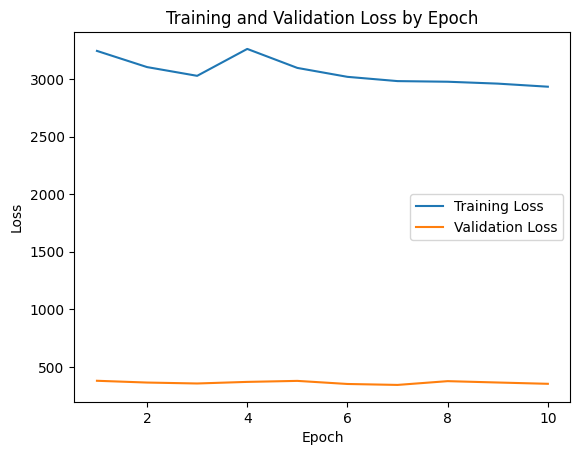

In [20]:
# REDACTED (GRAPH PRINTING CODE)

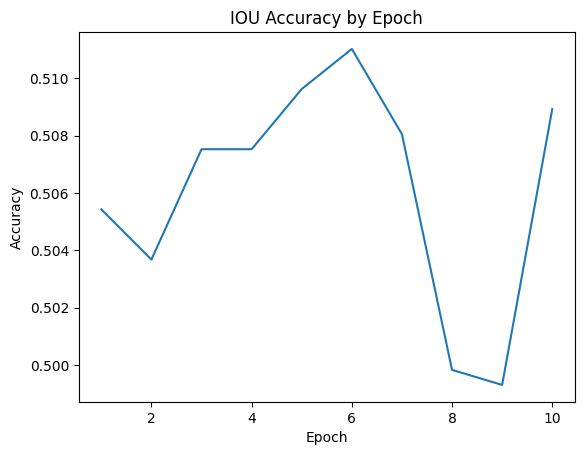

Best Accuracy: 51.10255512775639


In [21]:
# REDACTED (IOU GRAPH OUTPUT)

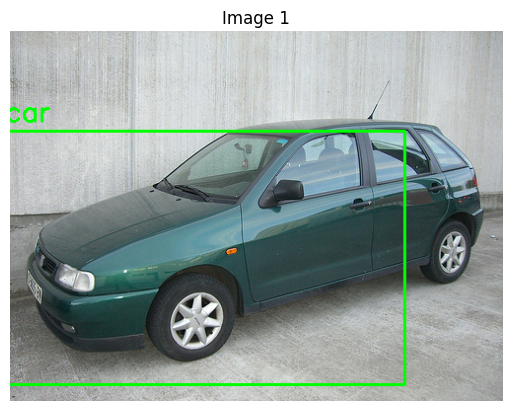

AVERAGE PRECISION: 1.0


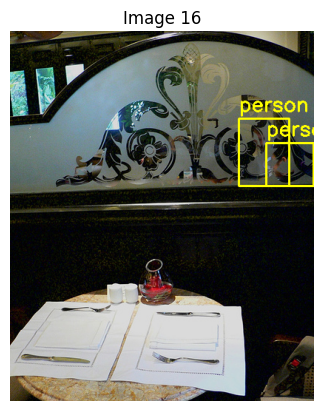

AVERAGE PRECISION: 0


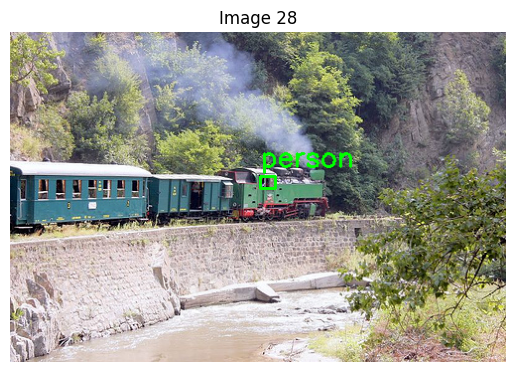

AVERAGE PRECISION: 1.0


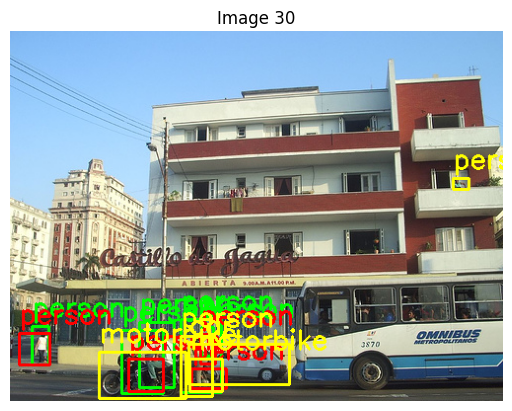

AVERAGE PRECISION: 0.7979797979797979


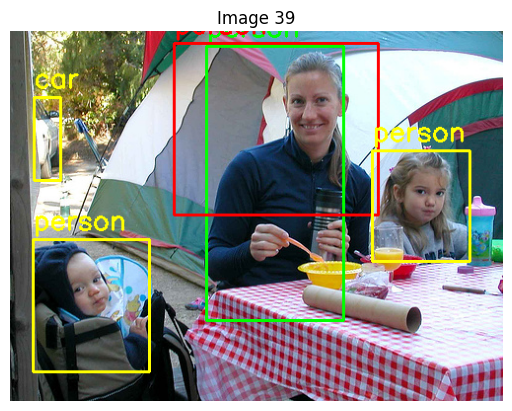

AVERAGE PRECISION: 0.6363636363636364


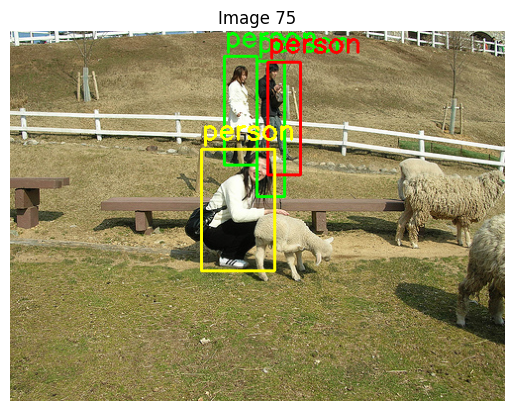

AVERAGE PRECISION: 0.8787878787878788


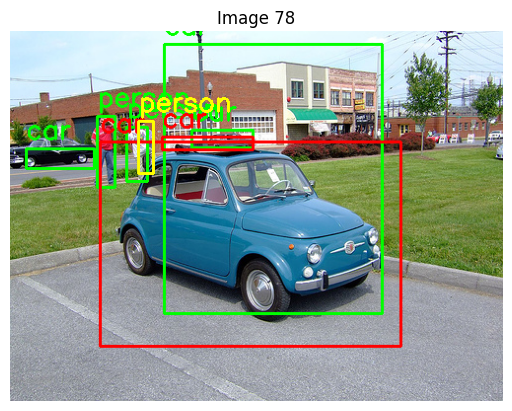

AVERAGE PRECISION: 0.896103896103896


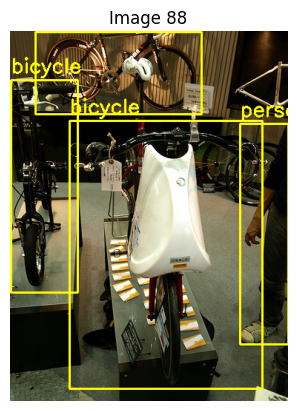

AVERAGE PRECISION: 0


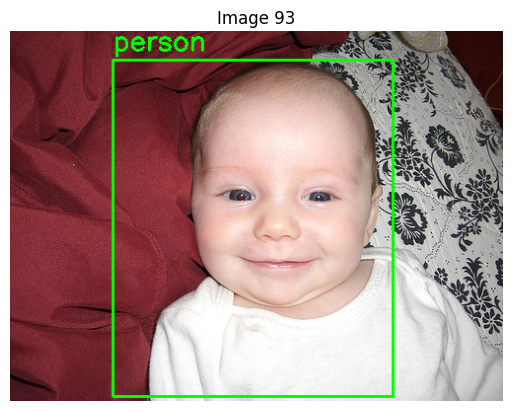

AVERAGE PRECISION: 1.0


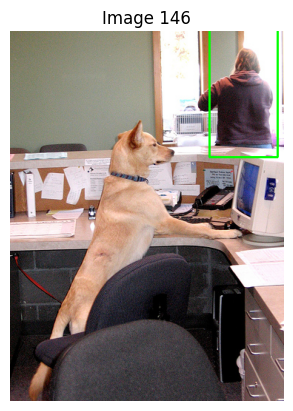

AVERAGE PRECISION: 1.0
MAP: 0.7242727639806361
PER CLASS ACCURACY:
Class bicycle: 52.72727272727273%
Class car: 48.538011695906434%
Class motorbike: 51.282051282051285%
Class person: 45.8137347130762%
PER CLASS GROUND TRUTH FOUND:
Class bicycle: 36.70886075949367%
Class car: 44.148936170212764%
Class motorbike: 28.985507246376812%
Class person: 53.16593886462882%


In [30]:
# TESTING DATA
test(test_dataloader,best_net,verbose_tests,LABELS_TO_NAMES,iou_threshold=0.5)

Once again to reiterate, **FOR A BETTER EXAMPLE OF TRAINING DATA PLOTS** see this older model with **SLIGHTLY WORSE ACCURACY** https://colab.research.google.com/drive/11bac2EZ2sDtbl6Cg57quZBKutATINoIc?usp=sharing

I am moderately satisfied with my results. Oftentimes I noticed that my network sees most of its training in the first few epochs (usually in the first epoch alone) and the rest exhibits slow growth OR declining results. I am unsure if this is overfitting but I have taken strong measures to prevent overfitting so I doubt it. My suspicion the problem lies in my loss functions and how I weight them (i.e. my network is not great at converging). I would like to get my network into the 70%+ range, but I neither have the time or colab credits to do so.

As for my specific results, my classification looks good but there is noticable bias in the dataset for the "nothing" class, with majority of the validation data being "nothing." In terms of per-class accuracies, my classification most commonly fails to detect bicycles (class 1, 75.6%) and nothing (class 0, 76.3%). When there is nothing my classification most commonly returns the false positive of "person" and when there is a bicycle it most commonly returns "nothing."
For regression, the biggest problem I see in the testing data is there are a lot of extraneous (red) detections. This is likely related to the IOU threshold in nonmaximum supression and is also grounds for better training (this would happen less if the model predicted more accurate bounding boxes). We also see that the overall regression tends to have the most false positives for pedestrians with a per-class accuracy of 46% (i.e. the model predicts "pedestrian" where there is none). We see the regression does very poorly at recognizing the presence of bikes and motorcycles, only being able to recognize 37% and 29% of them respectively. Note how these values are loosely related to the classification issues: nothing is most commonly missclassified as a pedestrian and bicycles are most commonly missclassified as nothing.

In general, here are the following ways which I would try to improve my network:
*   Lower IoU for nonmaximum supression during post-processing.
*   Redistribute loss function weights to incentivize classification more than currently.

I would also like to try more ways to optimize my code to run further. There are a lot of parameters which I had tweaked over my time on this homework which I am still unsure what the best values are (e.g. batch size, learning rate, number of hidden layers). Although my accuracy and loss graphs over time are janky, it does not appear overfit, so I could possibly try training this model further. My only suspicion is that, as with all my other trials, the accuracy barely improves beyond the first ten epochs. I would be welcome to any other suggestions on how to improve this.